In [2]:
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cvxpy as cp
from util import LoadData, generate_date_list, start, end, factors_list
from Optimizers import Optimizers, GetOptimalAllocation, drrpw_net
from FactorModelling import GetParameterEstimates
import PortfolioClasses as pc
import LossFunctions as lf
from torch.autograd import Variable
import torch

from torch.utils.data import DataLoader

def RunBacktest(path_to_data, opt_type, InitialValue=1000000, lookback = 30, datatype='broad'):
    returns, assets_list_cleaned, prices, factors = LoadData(path_to_data, e2e=True, datatype=datatype)
    holdings = pd.DataFrame(columns=['date']+assets_list_cleaned)
    portVal = pd.DataFrame(columns=['date', 'Wealth'])

    dates = generate_date_list(returns, prices, start=start, end=end)
    first = True
    
    for date in dates:
        # Get Asset Prices for Today
        currentPrices = (prices[prices['date']==str(date)]
            .drop('date',axis=1)
            .values
            .flatten())
        
        # Update Portfolio Value
        if first:
            portVal.loc[len(portVal)] = [date] + [InitialValue]
            CurrentPortfolioValue = InitialValue
            first = False
        else:     
            CurrentPortfolioValue = np.dot(currentPrices,noShares)
            portVal.loc[len(portVal)] = [date] + [CurrentPortfolioValue]
            
        # We don't want the current date information, hence the lack of equality
        # Get last 30
        date = str(date)
        
        returns_lastn = returns[(returns['date'] < date)].tail(lookback)
        asset_returns = returns_lastn.drop('date', axis=1)

        factor_returns = factors[(factors['date'] < date)].tail(lookback)
        factor_returns = factor_returns.drop('date', axis=1)

        mu, Q = GetParameterEstimates(asset_returns, factor_returns, log=False, bad=True)
        x = GetOptimalAllocation(mu, Q, opt_type)

        # Update Holdings
        holdings.loc[len(holdings)] = [date] + list(x)

        # Update shares held
        # 50% of 100k = 50k. If price is 100 we have 50,000/100=50 shares
        noShares = np.divide(x*CurrentPortfolioValue, currentPrices)
        print('Done {}'.format(date))
    
    portVal['date'] = pd.to_datetime(portVal['date'])
    portVal = portVal.merge(factors[['date','RF']], how='left', on='date')

    return holdings, portVal

In [ ]:
def RP(mu,Q):
    
    # # of Assets
    n = len(mu)

    # Decision Variables
    w = cp.Variable(n)

    # Kappa
    k = 2

    # Penalty
    lmda = 1
          
    constraints = [
        w>=0 # Disallow Short Sales
    ]

    # Objective Function
    risk = cp.quad_form(w, Q)
    log_term = 0
    for i in range(n):
        log_term += cp.log(w[i])
    
    prob = cp.Problem(cp.Minimize(risk-(k*log_term) + lmda*cp.norm(w, 1)), constraints=constraints)
    
    # ECOS fails sometimes, if it does then do SCS
    try:
        prob.solve(verbose=False)
    except:
        prob.solve(solver='SCS',verbose=False)

    x = w.value
    x = np.divide(x, np.sum(x))

    # Check Risk Parity Condition is actually met
    risk_contrib = np.multiply(x, Q.dot(x))
    if not np.all(np.isclose(risk_contrib, risk_contrib[0])):
        print("RP did not work")

    return x

In [4]:
import torch.nn as nn
import torch


In [5]:
class CardinalityLoss(nn.Module):
    def __init__(self, cardinality):
        super(CardinalityLoss, self).__init__()

        self.cardinality = cardinality

    def forward(self, output):
        penalty = 1000
        a = np.array([0]*self.cardinality)
        a[0] = -100
        b = np.array([penalty]*(len(output)-self.cardinality))
        penalty_vec = np.concatenate((b,a))
        penalty_tensor = torch.from_numpy(penalty_vec.astype('float64'))
        loss = torch.dot(output, penalty_tensor)
        return loss


In [7]:
import random

Text(0.5, 1.0, 'Cardinality Loss with n=20, k=10')

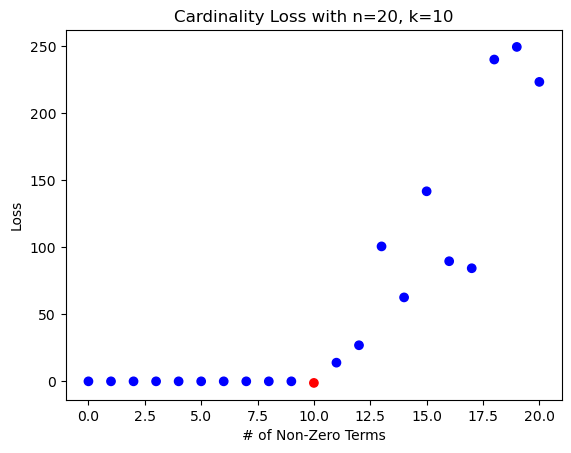

In [10]:
n = 20
k = 10
res_x = []
res_y = []
softmax = nn.Softmax()
for i in range(n+1):
    l_form = [0.]*(n-i)
    non_zero = [random.random() for _ in range(i)]
    non_zero = [x/sum(non_zero) for x in non_zero]
    l_form += non_zero
    input = torch.tensor(np.sort(l_form, axis=None), requires_grad=True)
    
    criterion = CardinalityLoss(k)
    output = criterion(input)

    res_x.append(i)
    res_y.append(float(output))
zmin = np.min(res_y)
mask = np.array(res_y) == zmin
color = np.where(mask, 'red', 'blue')

plt.scatter(res_x, res_y, color=color)
plt.xlabel('# of Non-Zero Terms')
plt.ylabel('Loss')
plt.title('Cardinality Loss with n={}, k={}'.format(n,k))


In [11]:
import numpy as np
import cvxpy as cvx

np.random.seed(12345)
n = 10
k = 6
mu = np.abs(np.random.randn(n, 1))
Sigma = np.random.randn(n, n)
Sigma = Sigma.T.dot(Sigma)
w = cvx.Variable(n)

ret = mu.T*w
risk = cvx.quad_form(w, Sigma)
objective = cvx.Maximize(ret - risk)

binary = cvx.Bool(n)  # !!!

constraints = [cvx.sum_entries(w) == 1, w>= 0, w - binary <= 0., cvx.sum_entries(binary) == k] # !!!

prob = cvx.Problem(objective, constraints)
prob.solve(verbose=True)

print(prob.status)

output = []
for i in range(len(w.value)):
    output.append(round(w[i].value,2))


print('Number of non-zero elements : ',sum(1 for i in output if i > 0))

c:\Users\Rafay\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 1 times so far.

  warnings.warn(msg, UserWarning)


AttributeError: module 'cvxpy' has no attribute 'Bool'

In [51]:
output.backward()

In [88]:
l = [0, 0, 0.2, 0.2, 0.2]



[0.2, 0.2, 0.2, 0, 0]

In [86]:
l

[0, 0, 0.2, 0.2, 0.2]

array([     0,      0,      0, 100000, 100000])

In [12]:
x = torch.zeros(3,3)
x[torch.randn(3,3) > 0.5] = 1
torch.count_nonzero(x)